In [9]:
import tensorflow as tf
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2S,EfficientNetV2M,EfficientNetV2L
from tensorflow.keras.applications.convnext import ConvNeXtTiny,ConvNeXtSmall,ConvNeXtBase
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
import os
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.data import AUTOTUNE
from sklearn.model_selection import KFold
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [10]:
def get_file_paths_and_labels(directory):
    file_paths = []
    labels = []
    class_names = sorted(os.listdir(directory))
    class_to_index = {class_name: idx for idx, class_name in enumerate(class_names)}

    for class_name in class_names:
        class_path = os.path.join(directory, class_name)
        for fname in os.listdir(class_path):
            fpath = os.path.join(class_path, fname)
            if os.path.isfile(fpath):
                file_paths.append(fpath)
                labels.append(class_to_index[class_name])

    return np.array(file_paths), np.array(labels), class_names

In [11]:
# 方法1：限制GPU記憶體成長
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


# 設定參數
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 16
EPOCHS = 500

# 資料路徑
TRAINING_DIR = "datasets/flower_photos/Training"
TEST_DIR = "datasets/flower_photos/Inference"


file_paths, labels, class_names = get_file_paths_and_labels(TRAINING_DIR)
num_classes = len(class_names)

In [12]:
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, 0.8, 1.2)
    # image = tf.image.random_hue(image, max_delta=0.2)
    # image = tf.image.random_saturation(image, 0.8, 1.2)
    # image = preprocess_input(image)
    label = tf.one_hot(label, num_classes)
    return image, label

def preprocess(image, label):
    # image = preprocess_input(image)
    label = tf.one_hot(label, num_classes)
    return image, label

In [13]:
def create_model(Model):
    base_model = Model(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    base_model.trainable = False

    model = Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [14]:
# def get_summary(Model_list):
#     for Model in Model_list:
#         m = create_model(Model)
#         print(m.summary())
#         del m
# get_summary([EfficientNetV2S,EfficientNetV2M,EfficientNetV2L,ConvNeXtTiny,ConvNeXtSmall,ConvNeXtBase])

In [15]:
# def create_model():
#     base_model = ConvNeXtBase(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
#     base_model.trainable = False

    # model = Sequential([
    #     base_model,
    #     layers.GlobalAveragePooling2D(),
    #     layers.Dense(256, activation='relu'),
    #     layers.Dropout(0.5),
    #     layers.Dense(num_classes, activation='softmax')
    # ])

#     model.compile(
#         optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
#         loss='categorical_crossentropy',
#         metrics=['accuracy']
#     )
#     return model

In [16]:
def plot_training_history(history, model_name):
    # 擷取訓練和驗證的損失與準確率
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    epochs_range = range(1, len(train_loss) + 1)

    # 創建畫布為 1x2 的子圖
    plt.figure(figsize=(12, 5))  

    # 作圖損失
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.title(f'{model_name} Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # 作圖準確率
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accuracy, label='Training Accuracy')
    plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
    plt.title(f'{model_name} Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # 顯示圖片
    plt.tight_layout()
    plt.savefig(f"{model_name} Loss and Accuracy")
    plt.show()

    
def plot_confusion_matrix(y_true, y_pred, labels=None, title='Confusion Matrix'):
    """
    繪製混淆矩陣的函數。
    
    參數:
    y_true: 真實標籤列表或數組。
    y_pred: 預測標籤列表或數組。
    labels: 標籤的名稱列表，用於標記矩陣的軸。
    title: 圖表的標題。
    """
    # 計算混淆矩陣
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # 創建一個熱圖，顯示混淆矩陣
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.savefig(f"Inference confusion metrix")
    plt.show()

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=labels, yticklabels=labels)

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'{title} normalized')
    plt.savefig(f"Inference confusion metrix normalized")
    plt.show()
    
def plot_misclassified_with_probabilities(test_dataset, model_name ,y_true, y_pred, y_probs, class_names, num_images_to_plot=5):
    """
    畫出預測錯誤的圖片。
    
    參數:
    - test_dataset: 用於測試的tf.data.Dataset物件。
    - y_true: 真實標籤的數組或列表。
    - y_pred: 預測標籤的數組或列表。
    - class_names: 分類標籤名稱的列表。
    - num_images_to_plot: 要顯示的錯誤圖片的數量。
    """
    # 找出預測錯誤的 index
      # 找出預測錯誤的 index
    incorrect_indices = np.where(np.array(y_true) != np.array(y_pred))[0]

    if len(incorrect_indices) == 0:
        print("所有圖片均正確分類！")
        return
    
    num_plots = min(num_images_to_plot, len(incorrect_indices))
    print(f"最少繪製'{num_plots}'張圖片")
    # 計算行列數目
    cols = 5
    rows = (num_plots + cols - 1) // cols  # 向上取整

    plt.figure(figsize=(15, 5 * rows))

    count = 0
    global_index = 0
    for images, _ in test_dataset:
        for i in range(len(images)): #batch?32
            if count >= num_plots:
                break
            if global_index in incorrect_indices:
                # 獲取該圖片真實標籤與預測信息
                true_label_index = class_names.get(y_true[global_index]) #0123
                predicted_label_index = class_names.get(y_pred[global_index]) #0123
                true_label_prob = y_probs[global_index][true_label_index]
                predicted_label_prob = y_probs[global_index][predicted_label_index]
                
                ax = plt.subplot(rows, cols, count + 1)
                plt.imshow(images[i].numpy().astype("int32"))  # 確保圖片是可視化格式
                plt.title(f"True: {y_true[global_index]} ({true_label_prob:.2f})\n"
                          f"Pred: {y_pred[global_index]} ({predicted_label_prob:.2f})")
                plt.axis("off")
                count += 1
            global_index += 1

        if count >= num_plots:
            break
    plt.title(f"{model_name} wrong predicted images")
    plt.tight_layout()
    plt.savefig(f"{model_name} wrong predicted images")
    plt.show()


========== Fold 1 ==========
Epoch 1/500


2025-04-22 02:15:17.374310: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 90500
I0000 00:00:1745288117.746901 1446768 service.cc:145] XLA service 0x7f4d0631b300 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745288117.746924 1446768 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
I0000 00:00:1745288117.893079 1446768 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 1/93 [..............................] - ETA: 35:20 - loss: 1.7978 - accuracy: 0.1875

2025-04-22 02:15:19.733809: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


93/93 [==============================] - ETA: 0s - loss: 0.2960 - accuracy: 0.9099

/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


93/93 [==============================] - 44s 223ms/step - loss: 0.2960 - accuracy: 0.9099 - val_loss: 0.1028 - val_accuracy: 0.9709 - lr: 5.0000e-04
Epoch 2/500
93/93 [==============================] - 12s 126ms/step - loss: 0.0595 - accuracy: 0.9844 - val_loss: 0.0810 - val_accuracy: 0.9756 - lr: 5.0000e-04
Epoch 3/500
93/93 [==============================] - 12s 124ms/step - loss: 0.0405 - accuracy: 0.9898 - val_loss: 0.0730 - val_accuracy: 0.9763 - lr: 5.0000e-04
Epoch 4/500
93/93 [==============================] - 12s 125ms/step - loss: 0.0235 - accuracy: 0.9946 - val_loss: 0.0684 - val_accuracy: 0.9790 - lr: 5.0000e-04
Epoch 5/500
93/93 [==============================] - 11s 119ms/step - loss: 0.0188 - accuracy: 0.9973 - val_loss: 0.0736 - val_accuracy: 0.9783 - lr: 5.0000e-04
Epoch 6/500
93/93 [==============================] - 12s 124ms/step - loss: 0.0180 - accuracy: 0.9959 - val_loss: 0.0675 - val_accuracy: 0.9790 - lr: 5.0000e-04
Epoch 7/500
93/93 [===========================

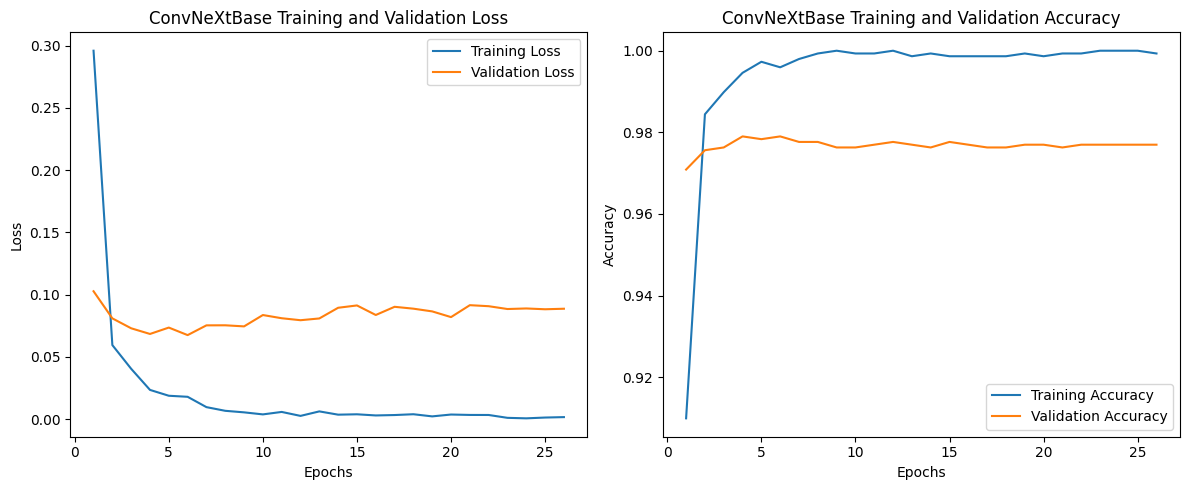

Found 607 files belonging to 5 classes.


2025-04-22 02:20:32.132898: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


19/19 [==============================] - 4s 154ms/step - loss: 0.0689 - accuracy: 0.9703
Inference Test Accuracy (Last Fold): 0.9703
19/19 [==============================] - 6s 90ms/step


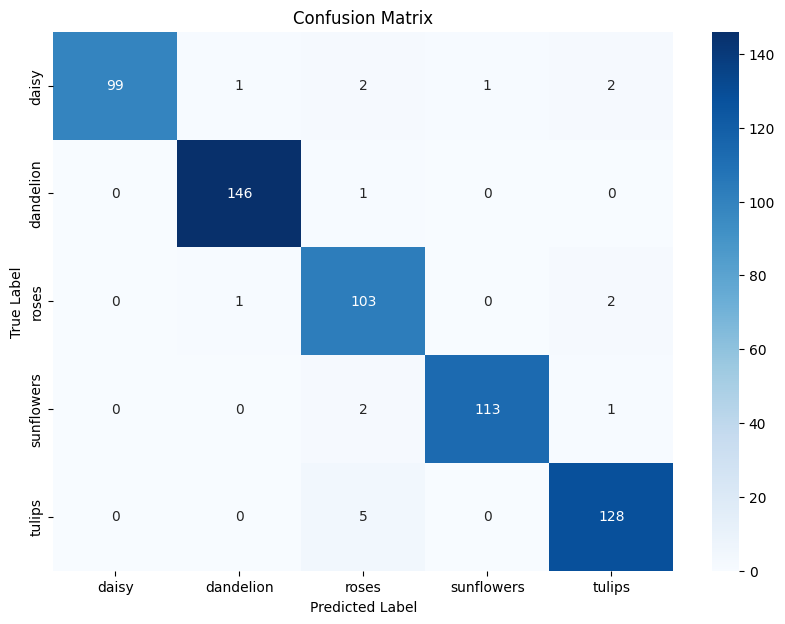

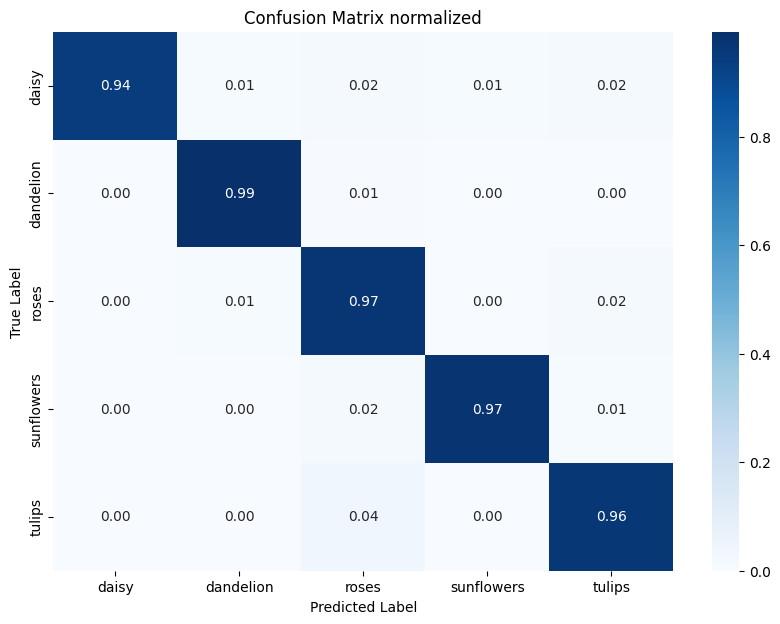

最少繪製'18'張圖片


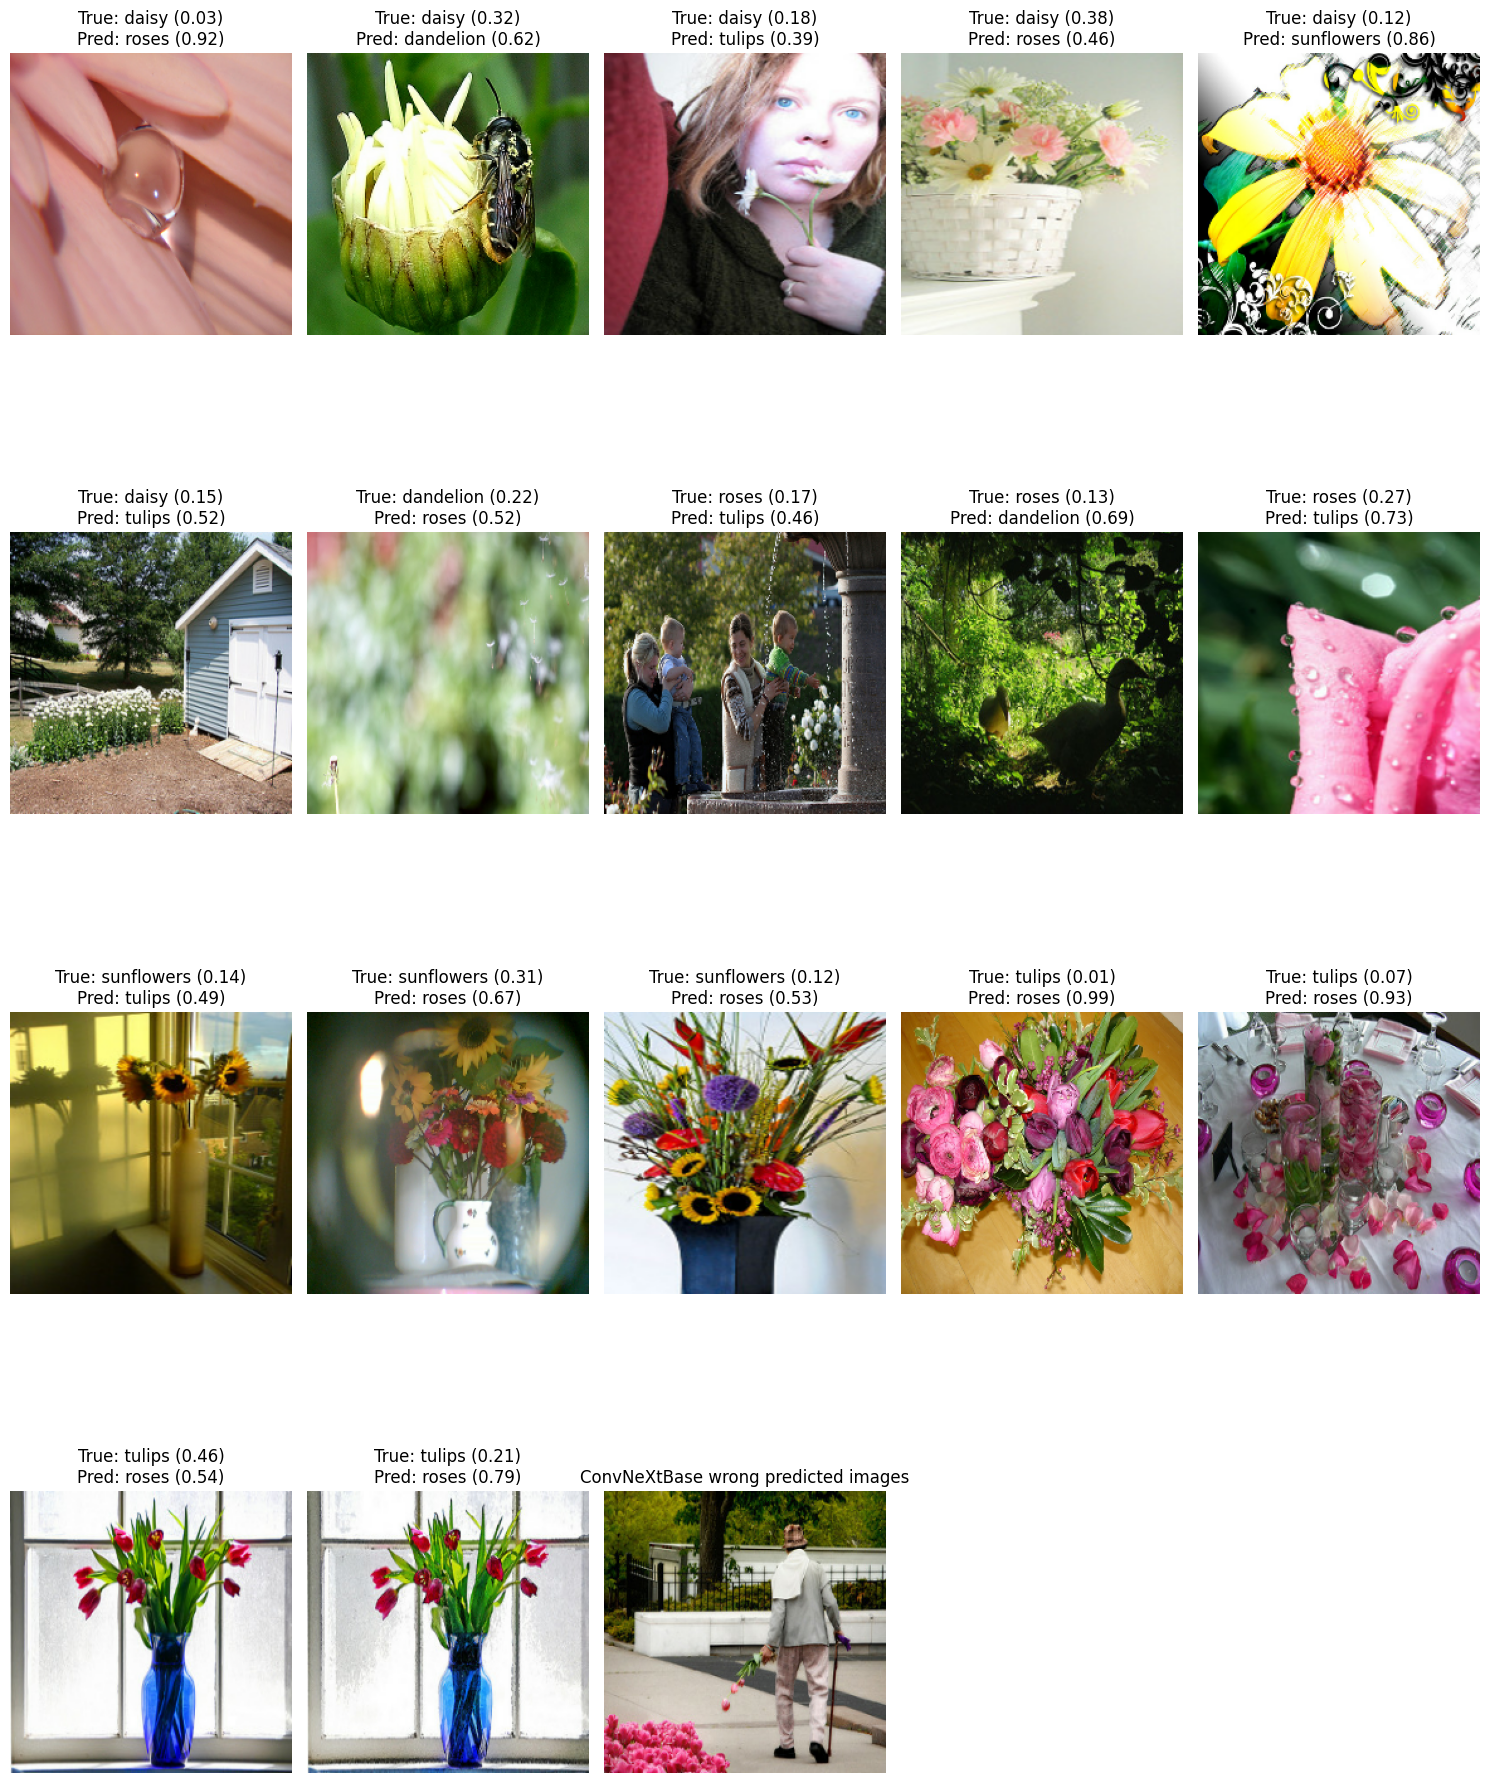


========== Fold 2 ==========
Epoch 1/500
93/93 [==============================] - ETA: 0s - loss: 0.3385 - accuracy: 0.8963

/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


93/93 [==============================] - 36s 224ms/step - loss: 0.3385 - accuracy: 0.8963 - val_loss: 0.0857 - val_accuracy: 0.9824 - lr: 5.0000e-04
Epoch 2/500
93/93 [==============================] - 25s 266ms/step - loss: 0.0733 - accuracy: 0.9783 - val_loss: 0.0841 - val_accuracy: 0.9810 - lr: 5.0000e-04
Epoch 3/500
93/93 [==============================] - 26s 279ms/step - loss: 0.0474 - accuracy: 0.9892 - val_loss: 0.0767 - val_accuracy: 0.9804 - lr: 5.0000e-04
Epoch 4/500
93/93 [==============================] - 26s 282ms/step - loss: 0.0201 - accuracy: 0.9973 - val_loss: 0.0773 - val_accuracy: 0.9837 - lr: 5.0000e-04
Epoch 5/500
93/93 [==============================] - 26s 281ms/step - loss: 0.0249 - accuracy: 0.9966 - val_loss: 0.0806 - val_accuracy: 0.9824 - lr: 5.0000e-04
Epoch 6/500
93/93 [==============================] - 26s 282ms/step - loss: 0.0181 - accuracy: 0.9953 - val_loss: 0.0717 - val_accuracy: 0.9837 - lr: 5.0000e-04
Epoch 7/500
93/93 [===========================

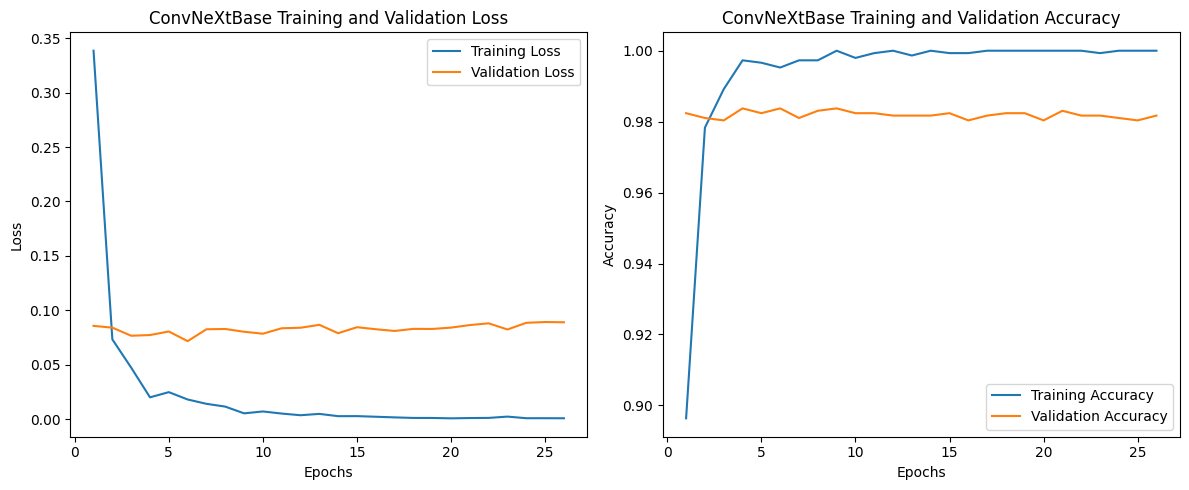

Found 607 files belonging to 5 classes.


2025-04-22 02:32:19.822502: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


19/19 [==============================] - 6s 290ms/step - loss: 0.0660 - accuracy: 0.9786
Inference Test Accuracy (Last Fold): 0.9786
19/19 [==============================] - 8s 222ms/step


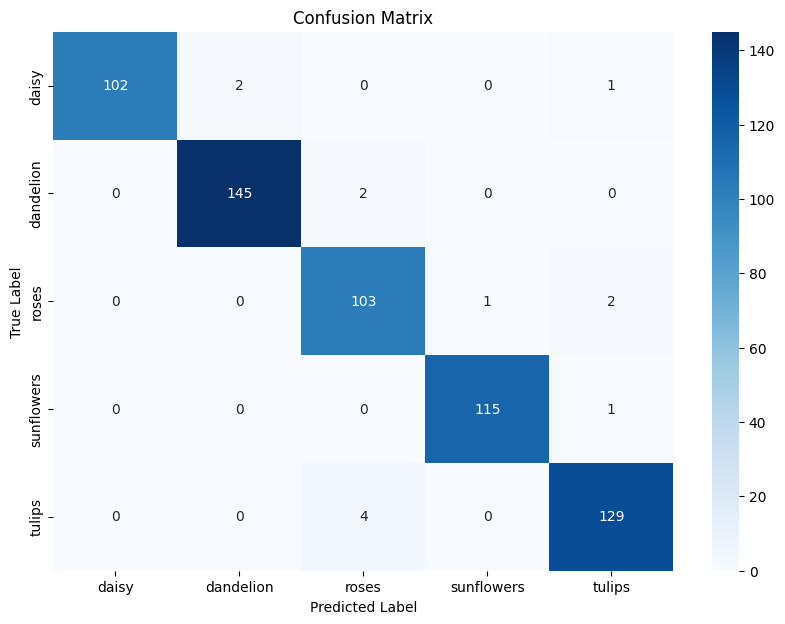

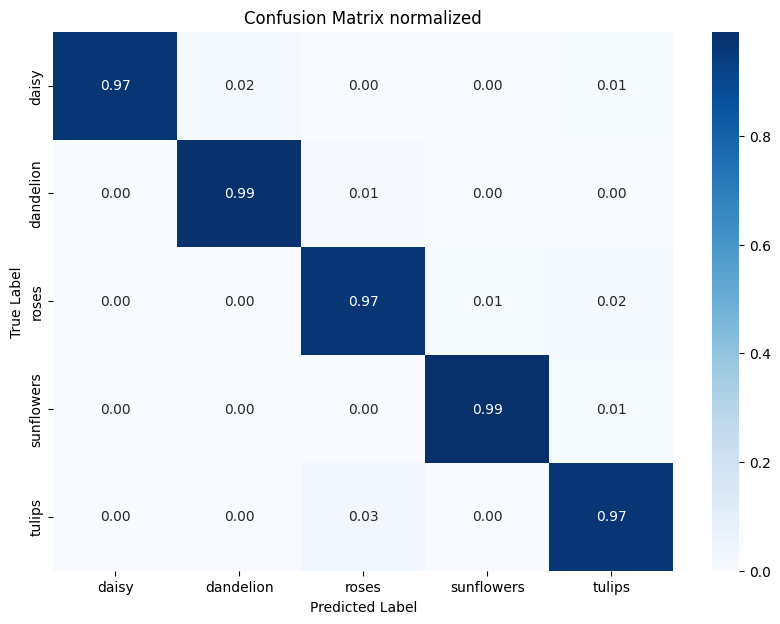

最少繪製'13'張圖片


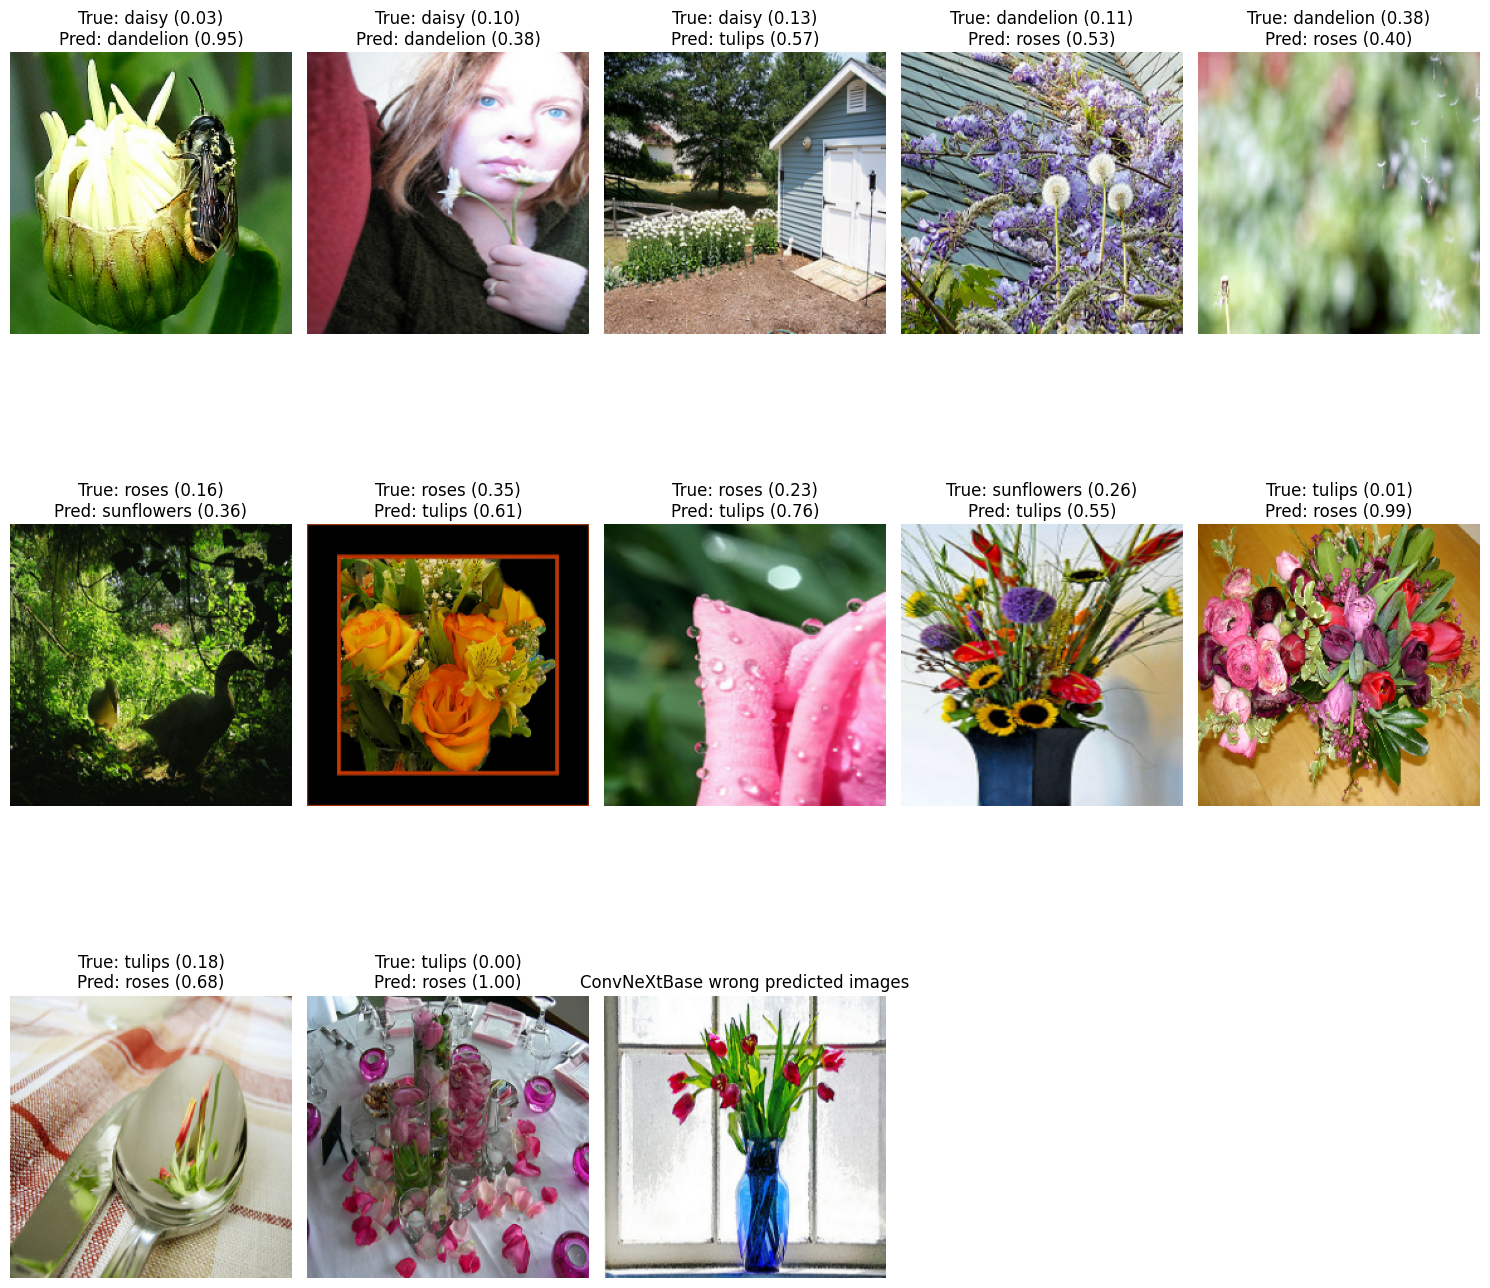

In [18]:
kf = KFold(n_splits=2, shuffle=True, random_state=26)

for fold, (train_idx, val_idx) in enumerate(kf.split(file_paths)):
    print(f"\n========== Fold {fold + 1} ==========")
    train_paths, val_paths = file_paths[train_idx], file_paths[val_idx]
    train_labels, val_labels = labels[train_idx], labels[val_idx]

    # 建立 Dataset
    train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
    val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))

    # 讀圖片
    def load_and_preprocess_image(path, label):
        image = tf.io.read_file(path)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
        return image, label

    train_ds = train_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE).map(augment)
    train_ds = train_ds.shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    val_ds = val_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE).map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    # 建立 model & callbacks
    model = create_model(ConvNeXtBase
        
    )

    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=9, min_lr=1e-6),
        tf.keras.callbacks.ModelCheckpoint(f'0422_ConvNeXtBase_best_model_fold{fold + 1}.h5', monitor='val_accuracy', save_best_only=True, mode='max')
    ]

    history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=callbacks)
    plot_training_history(history,"ConvNeXtBase")
    test_dataset = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    shuffle=False
    )
    test_dataset = test_dataset.map(preprocess)
    true_labels = []
    for _, label in test_dataset:
        batch_labels = label.numpy()
        class_indices = np.argmax(batch_labels, axis=1)
        true_labels.extend(class_indices)

    # 最後一個 fold 測試
    loss, acc = model.evaluate(test_dataset)
    print(f"Inference Test Accuracy (Last Fold): {acc:.4f}")
    with open("test_inference.txt","+a",encoding="utf-8") as file:
        file.write(f"Fold {fold+1} Inference metric loss:{loss}, acc:{acc}\n")
    evaluate_result = model.evaluate(test_dataset)
    predict_result = model.predict(test_dataset)
    predict_classes = np.argmax(predict_result,axis=1)
    reverse_name = {k:v for k,v in enumerate(class_names)}
    y_true = [reverse_name.get(i) for i in true_labels]
    y_pred = [reverse_name.get(i) for i in predict_classes]
    name_to_int = {v:k for k,v in enumerate(class_names)}
    plot_confusion_matrix(y_true=y_true,y_pred=y_pred,labels=class_names)
    plot_misclassified_with_probabilities(test_dataset, model_name="ConvNeXtBase",y_true=y_true, y_pred=y_pred, y_probs=predict_result, class_names=name_to_int, num_images_to_plot=100)


In [ ]:
# model= create_model(ConvNeXtBase)
# model.load_weights("model/ConvNeXtBase_best_model_fold1.h5")

In [ ]:
# test_dataset = tf.keras.utils.image_dataset_from_directory(
#     TEST_DIR,
#     image_size=(IMG_HEIGHT, IMG_WIDTH),
#     shuffle=False
#     )
# test_dataset = test_dataset.map(preprocess)
# true_labels = []
# for _, label in test_dataset:
#     batch_labels = label.numpy()
#     class_indices = np.argmax(batch_labels, axis=1)
#     true_labels.extend(class_indices)

# # 最後一個 fold 測試
# loss, acc = model.evaluate(test_dataset)
# print(f"Inference Test Accuracy (Last Fold): {acc:.4f}")
# with open("test_inference.txt","+a",encoding="utf-8") as file:
#     file.write(f"TESTING Inference metric loss:{loss}, acc:{acc}\n")
# evaluate_result = model.evaluate(test_dataset)
# predict_result = model.predict(test_dataset)
# predict_classes = np.argmax(predict_result,axis=1)
# reverse_name = {k:v for k,v in enumerate(class_names)}
# y_true = [reverse_name.get(i) for i in true_labels]
# y_pred = [reverse_name.get(i) for i in predict_classes]
# name_to_int = {v:k for k,v in enumerate(class_names)}
# plot_confusion_matrix(y_true=y_true,y_pred=y_pred,labels=class_names)
# plot_misclassified_with_probabilities(test_dataset, model_name="ConvNeXtSmall",y_true=y_true, y_pred=y_pred, y_probs=predict_result, class_names=name_to_int, num_images_to_plot=100)
